# Importing Libraries and Reading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv',
                 index_col='FullDate',
                 parse_dates=True)

In [30]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [32]:
# getting the daily sampling rate(sum)
df_daily = df.resample('D').sum()

df_daily.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


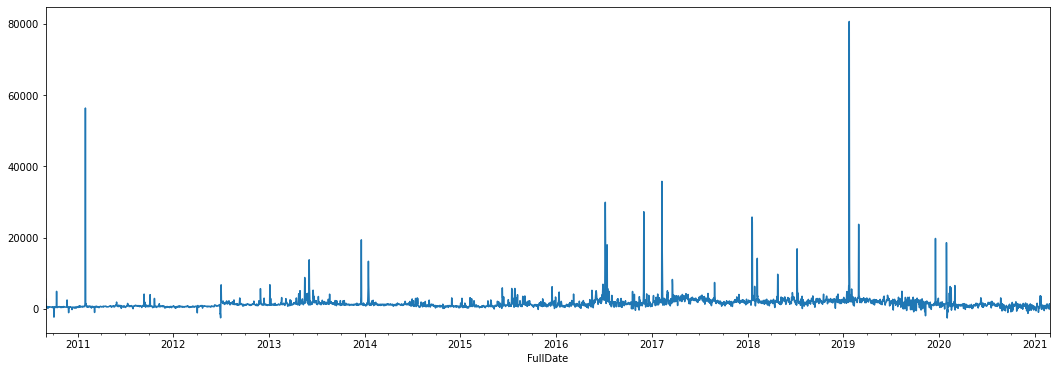

In [65]:
df_daily['ElecPrice'].plot(figsize=(18,6));

In [66]:
from statsmodels.tsa.stattools import adfuller

In [67]:
# checking the p value for SysLoad
adf_result = adfuller(df_daily[ 'SysLoad' ])
print("SysLoad p value", adf_result[1])

# checking the p value for GasPrice
adf_result = adfuller(df_daily[ 'GasPrice' ])
print("GasPrice p value ", adf_result[1])

SysLoad p value 0.004253725504574117
GasPrice p value  0.04502721288462542


In [68]:
print("Critical values for GasPrice:")

for k, v in adf_result[ 4 ].items():
  print( f' {k} : {v} ' )

Critical values for GasPrice:
 1% : -3.4320693157877544 
 5% : -2.8622996992165364 
 10% : -2.5671743978048323 


In [69]:
# checking the critical values for ElecPrice
adf_result = adfuller(df_daily[ 'ElecPrice' ])

print("Critical values for ElecPrice:")

for k, v in adf_result[ 4 ].items():
  print( f' {k} : {v} ' )

Critical values for ElecPrice:
 1% : -3.432066157296446 
 5% : -2.8622983040036005 
 10% : -2.5671736550459663 


In [33]:
train = df_daily.iloc[:2757]
test = df_daily.iloc[2757:]

In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1077 entries, 2018-03-20 to 2021-02-28
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       1077 non-null   float64
 1   SysLoad    1077 non-null   float64
 2   GasPrice   1077 non-null   float64
 3   ElecPrice  1077 non-null   float64
dtypes: float64(4)
memory usage: 42.1 KB


In [41]:
train_uni = train[['ElecPrice']]

In [42]:
# renaming the columns for the training data for univariate
train_uni = train_uni.rename(columns={'ElecPrice': 'y'})
train_uni.index.names = ['ds']

In [50]:
train_uni = train_uni.reset_index()

train_uni.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


# Using prophet for univariate time series

In [45]:
from prophet import Prophet

In [46]:
model_uni = Prophet()

In [51]:
model_uni.fit(train_uni)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktfks_2g/wizfpbpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktfks_2g/wx1l6q0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64018', 'data', 'file=/tmp/tmpktfks_2g/wizfpbpu.json', 'init=/tmp/tmpktfks_2g/wx1l6q0g.json', 'output', 'file=/tmp/tmpktfks_2g/prophet_modeltht8udfy/prophet_model-20230131194740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## predicting for the next 1077 days

In [53]:
future_uni = model_uni.make_future_dataframe(periods=1077, freq='D')

In [54]:
forecast_uni = model_uni.predict(future_uni)

In [56]:
forecast_uni.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,848.802868,-1430.330479,3489.162807,848.802868,848.802868,143.934254,143.934254,143.934254,159.353195,159.353195,159.353195,-15.418942,-15.418942,-15.418942,0.0,0.0,0.0,992.737122
1,2010-09-02,848.765391,-1212.891290,3465.788238,848.765391,848.765391,224.225577,224.225577,224.225577,257.107547,257.107547,257.107547,-32.881970,-32.881970,-32.881970,0.0,0.0,0.0,1072.990968
2,2010-09-03,848.727914,-1390.284171,3154.653270,848.727914,848.727914,-0.808614,-0.808614,-0.808614,50.273097,50.273097,50.273097,-51.081712,-51.081712,-51.081712,0.0,0.0,0.0,847.919300
3,2010-09-04,848.690437,-1710.079854,2942.550385,848.690437,848.690437,-341.125956,-341.125956,-341.125956,-271.443120,-271.443120,-271.443120,-69.682836,-69.682836,-69.682836,0.0,0.0,0.0,507.564481
4,2010-09-05,848.652960,-1913.763492,2932.949800,848.652960,848.652960,-431.103276,-431.103276,-431.103276,-342.724784,-342.724784,-342.724784,-88.378492,-88.378492,-88.378492,0.0,0.0,0.0,417.549684


In [82]:
def mape(y_true, y_hat):
  residual = np.abs((y_true - y_hat) / y_true)

  return round(np.mean(residual) * 100, 2)




In [83]:
mape(test['ElecPrice'].values, forecast_uni['yhat'].iloc[2757:].values)

544.73

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [87]:
print("RMSE: ", np.sqrt(mean_squared_error(test['ElecPrice'].values, forecast_uni['yhat'].iloc[2757:].values)))

RMSE:  3208.0625067777974


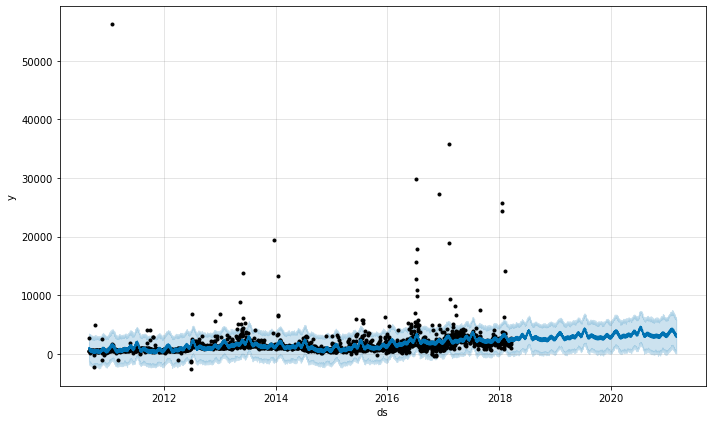

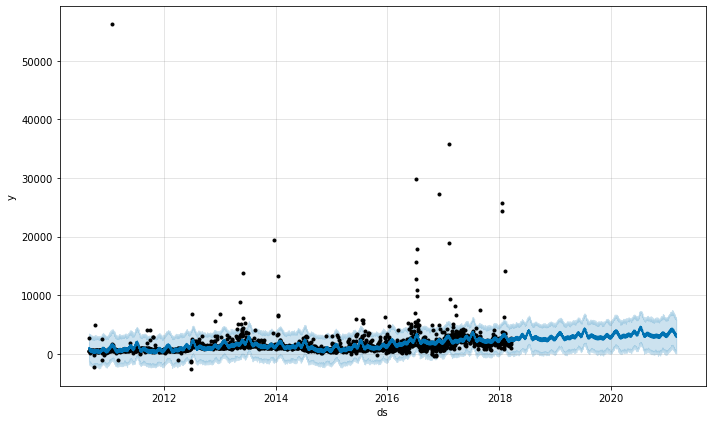

In [88]:
model_uni.plot(forecast_uni)

# Using Prophet for Multivariate Time Series

In [93]:
train.head()

,ds,add1,add2,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [94]:
train = train.rename(columns={'Tmax': 'add1', 'SysLoad': 'add2', 'GasPrice': 'add3', 'ElecPrice': 'y'})

train.head()

,ds,add1,add2,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [95]:
train = train.reset_index()

In [96]:
model = Prophet()

In [97]:
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktfks_2g/gxnf1l9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktfks_2g/imocglvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66257', 'data', 'file=/tmp/tmpktfks_2g/gxnf1l9n.json', 'init=/tmp/tmpktfks_2g/imocglvl.json', 'output', 'file=/tmp/tmpktfks_2g/prophet_modelpcd42r5b/prophet_model-20230131205812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Predicting for the next 1077 days

In [98]:
future = model.make_future_dataframe(periods=1077, freq='D')

In [99]:
forecast = model.predict(future)

In [100]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-01,848.802868,-1424.501105,3392.027043,848.802868,848.802868,143.934254,143.934254,143.934254,159.353195,159.353195,159.353195,-15.418942,-15.418942,-15.418942,0.0,0.0,0.0,992.737122
1,2010-09-02,848.765391,-1337.139793,3488.737356,848.765391,848.765391,224.225577,224.225577,224.225577,257.107547,257.107547,257.107547,-32.881970,-32.881970,-32.881970,0.0,0.0,0.0,1072.990968
2,2010-09-03,848.727914,-1370.728297,3124.710392,848.727914,848.727914,-0.808614,-0.808614,-0.808614,50.273097,50.273097,50.273097,-51.081712,-51.081712,-51.081712,0.0,0.0,0.0,847.919300
3,2010-09-04,848.690437,-2049.898256,2955.723785,848.690437,848.690437,-341.125956,-341.125956,-341.125956,-271.443120,-271.443120,-271.443120,-69.682836,-69.682836,-69.682836,0.0,0.0,0.0,507.564481
4,2010-09-05,848.652960,-1945.666779,2804.422175,848.652960,848.652960,-431.103276,-431.103276,-431.103276,-342.724784,-342.724784,-342.724784,-88.378492,-88.378492,-88.378492,0.0,0.0,0.0,417.549684


In [101]:
mape(test['ElecPrice'].values, forecast['yhat'].iloc[2757:].values)

544.73